# Exploração dos Dados

## Carregando o dataset

http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [1]:
# Pacotes importantes para este projeto
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
from pandas import Series
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
dfMovies = pd.read_csv("./ml-latest-small/movies.csv")
dfRatings = pd.read_csv("./ml-latest-small/ratings.csv")
dfTags = pd.read_csv("./ml-latest-small/tags.csv")
dfLinks = pd.read_csv("./ml-latest-small/links.csv")

# print("Movies:")
# print(dfMovies.head())
# print("Ratings:")
# print(dfRatings.head())
# print("Tags:")
# print(dfTags.head())
# print("Links:")
# print(dfLinks.head())

# Faz o merge do dataset utilizando os id's dos filmes como chave
dfMoviesRatings = pd.merge(dfMovies, dfRatings, on=['movieId'])

## Pré-processando os dados

In [3]:
# Separando os filmes e os títulos
moviesTitles = dfMoviesRatings[['movieId', 'title']]
moviesTitles = moviesTitles.set_index('movieId')
moviesTitles = moviesTitles.drop_duplicates()
moviesTitles.head()

# Remove colunas que não serão utilizadas no treinamento do sistema de recomendação
dfMoviesRatings = dfMoviesRatings.drop(['timestamp', 'title'], 1)
print(dfMoviesRatings.head())

   movieId                                       genres  userId  rating
0        1  Adventure|Animation|Children|Comedy|Fantasy       7     3.0
1        1  Adventure|Animation|Children|Comedy|Fantasy       9     4.0
2        1  Adventure|Animation|Children|Comedy|Fantasy      13     5.0
3        1  Adventure|Animation|Children|Comedy|Fantasy      15     2.0
4        1  Adventure|Animation|Children|Comedy|Fantasy      19     3.0


### Dados nulos ou faltantes

In [4]:
print("Movies - Null values: {}".format(dfMovies.isnull().any().any()))
print("Ratings - Null values: {}".format(dfRatings.isnull().any().any()))
print("Tags - Null values: {}".format(dfTags.isnull().any().any()))
print("Links - Null values: {}".format(dfLinks.isnull().any().any()))

Movies - Null values: False
Ratings - Null values: False
Tags - Null values: False
Links - Null values: True


### Análise e processamento das categorias

    Nesta etapa estou verificando quais as categorias que são encontradas no dataset:
    - categorias repetidas;
    - itens que não correspondem às categorias;

In [5]:
# Encontra todas as categorias presentes no dataset
dfCategories = dfMoviesRatings.genres.str.split(pat="|", expand=True)
dfCategories = Series(dfCategories.values.ravel()).unique()
dfCategories

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', None,
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'Documentary', 'IMAX', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [6]:
# Insere as colunas de cada categoria  
for col in dfCategories:
    dfMoviesRatings.insert(loc= len(dfMoviesRatings.columns), column=col, value=0)
dfMoviesRatings.head()

,movieId,genres,userId,rating,Adventure,Animation,Children,Comedy,Fantasy,None,...,Horror,Mystery,Sci-Fi,Documentary,IMAX,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Adventure|Animation|Children|Comedy|Fantasy,7,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Adventure|Animation|Children|Comedy|Fantasy,9,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Adventure|Animation|Children|Comedy|Fantasy,13,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Adventure|Animation|Children|Comedy|Fantasy,15,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Adventure|Animation|Children|Comedy|Fantasy,19,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Transforma cada categoria em uma feature
count = 0
for i, row in dfMoviesRatings.iterrows():
    dfMoviesRatings.set_value(col=row[1].split(sep="|"), index=i, value=1)

dfMoviesRatings.head()

,movieId,genres,userId,rating,Adventure,Animation,Children,Comedy,Fantasy,None,...,Horror,Mystery,Sci-Fi,Documentary,IMAX,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Adventure|Animation|Children|Comedy|Fantasy,7,3.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Adventure|Animation|Children|Comedy|Fantasy,9,4.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Adventure|Animation|Children|Comedy|Fantasy,13,5.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Adventure|Animation|Children|Comedy|Fantasy,15,2.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,Adventure|Animation|Children|Comedy|Fantasy,19,3.0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


Nesta célula estou removendo as colunas "None" e "(no genres listed)" que não correspondem às categorias de filmes. 

In [8]:
# Remove as categorias: None, '(no genres listed)'
dfMoviesRatings = dfMoviesRatings.drop([None, '(no genres listed)','genres'], 1)

### Tags

    - Avaliar os tags mais comuns;
    - Existe relação das tags com as avaliações? Palavras positivas e negativas?

### Análise e processamento dos nomes dos filmes

    - Avaliar se existem nomes de um mesmo filme com escritas diferentes;
    - 

### Análise e processamentos dos ratings

    - Normalizar os valores;

#### Verificar se o número de ratings é uniforme entre os filmes

TODO: Detalhar observações

Algumas estatísticas:


count    9066.000000
mean       11.030664
std        24.050800
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       341.000000
dtype: float64

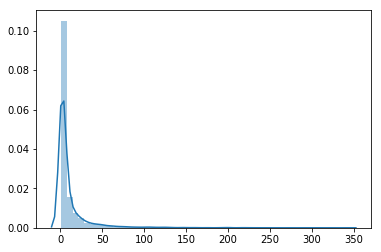

In [9]:
# Verifica o número de avaliações por filme
number_of_ratings_per_movie = pd.value_counts(dfMoviesRatings['movieId'].values, sort=False)

# Apresenta o gráfico com a distribuição o número de avaliações por filme
sns.distplot(pd.Series(number_of_ratings_per_movie, name=""))

# Algumas estatísticas
print('Algumas estatísticas:')
number_of_ratings_per_movie.describe()

Algumas estatísticas:


count    6003.000000
mean       16.148759
std        28.215085
min         2.000000
25%         3.000000
50%         6.000000
75%        16.000000
max       341.000000
Name: 0, dtype: float64

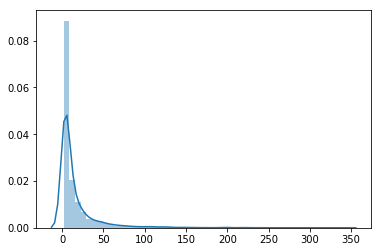

In [10]:
# Retirando 10% dos filmes que apresentam muito menos ratings que os demais 90%
new_data = number_of_ratings_per_movie.to_frame()[number_of_ratings_per_movie > 
                                                  number_of_ratings_per_movie.quantile(0.10)]

sns.distplot(pd.Series(new_data[0], name=""))

# Algumas estatísticas
print('Algumas estatísticas:')
new_data[0].describe()


A seguir são removidos os filmes que apresentam um número de ratings muito menor que os demais. Isso se deve ao fato de que as avaliações destes filmes são pouco expressivas diante dos demais filmes. O método de machine learning teria dificuldade para generalizar tendo tão poucas amostras.

In [11]:
# Obtendo o dataset final retirando 10% dos filmes que apresentam muito menos ratings que os demais 80%
new_data["movieId"] = new_data.index
dfMoviesRatingsFinal = pd.merge(dfMoviesRatings, new_data, how='inner', on=['movieId'])
dfMoviesRatingsFinal = dfMoviesRatingsFinal.rename(columns={0: 'NumberRatings'})
dfMoviesRatingsFinal.head()

,movieId,userId,rating,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,Documentary,IMAX,War,Musical,Western,Film-Noir,NumberRatings
0,1,7,3.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,247
1,1,9,4.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,247
2,1,13,5.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,247
3,1,15,2.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,247
4,1,19,3.0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,247


## Conclusões

### Existe alguma relação entre a categoria do filme e a forma que ele é avaliado?

Para avaliar se existe relação entre o rating e as categorias de filmes foi calculada a matriz de correlação, através da função ```corr()``` do pacote Pandas (linha 4). Além disso, foram apresentadas somente as correlações associadas ao rating (linha 7). Foi utilizada uma tabela de cores para facilitar a visualização dos dados. As cores mais próximas do vermelho ou azul apresentam correlações positivas ou negativas, respectivamente. Já as cores mais próximas do cinza apresentam baixa correlação.

O gráfico abaixo mostra que somente algumas categorias estão relacionadas com os ratings como, por exemplo, comédia, drama e ação. 

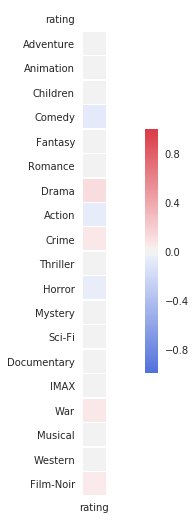

In [12]:
sns.set(style="white")

# Calcula a matriz de correlação das categorias
corr = dfMoviesRatingsFinal.drop(['movieId', 'NumberRatings','userId'],1).corr()

# Gera uma máscara para a parte superior do triângulo
corrRating = corr[['rating']]
mask = np.zeros_like(corrRating, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Define a area de render do gráfico
f, ax = plt.subplots(figsize=(14, 9))

# Gera o colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Deseja o mapa de calor com a correlação entre as categorias
sns.heatmap(corrRating, mask=mask, cmap=cmap, vmax=1., vmin=-1.,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Quais são as categorias que possuem relação entre si?
Para verificar a relação entre as categorias é calculado a matriz de correlação, como apresentado na linha 4 da célula a seguir.
    
Existe uma grande correlação entre algumas categorias, como podemos observar na matriz de correlação apresentada abaixo. Podemos citar como exemplo o fato dos filmes de animação estarem relacionados a filmes infantis (correlação de 0.66). Esta correlação faz sentido visto que a grande maioria dos filmes de animação são direcionados ao público infantil. A mesma análise pode ser feita para categorias com correlação negativa. Neste contexto, podemos citar que os gêneros comédia e suspense não coexistem. Da mesma que filmes de suspense e musicais ou animações.

Já alguns gêneros, como documentário e musical, tem correlação muito próxima de zero estando pouco relacionados.

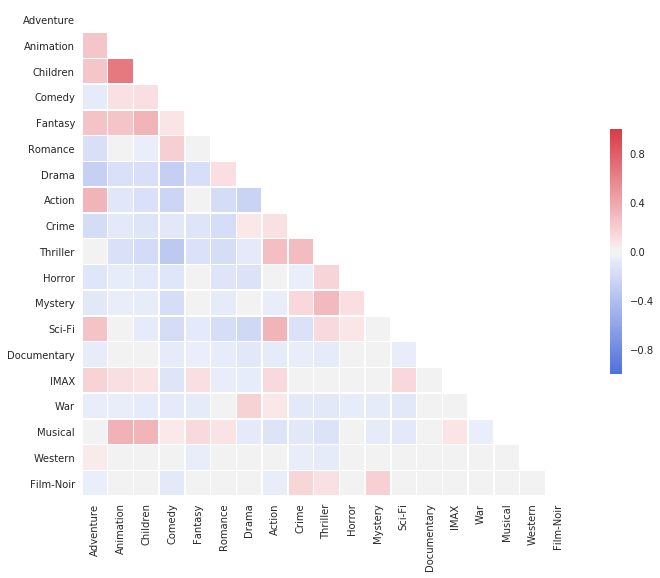

In [13]:
sns.set(style="white")

# Calcula a matriz de correlação das categorias
corr = dfMoviesRatingsFinal.drop(['movieId', 'rating', 'NumberRatings', 'userId'],1).corr()

# Gera uma máscara para a parte superior do triângulo
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Define a area de render do gráfico
f, ax = plt.subplots(figsize=(14, 9))

# Gera o colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Deseja o mapa de calor com a correlação entre as categorias
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., vmin=-1.,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

A seguir são apresentadas as correlações entre as categorias dos filmes com os respectivos valores.

In [14]:
# Filmes com maior correlação
print("Filmes com correlação POSITIVA")
dfMax = corr[ corr[:] == np.max(corr[corr[:] != 1]) ]
for row in corr:
    # Categoria corrente
    currentCategoryName = corr.columns[corr.columns == row][0]
    # Categoria com a maior correlação 
    correlatedCategory = dfMax[row].dropna().index[0]
    # Correlação
    correlation = dfMax[row].dropna()[0]
    # Imprimi as maiores correlações entre as categorias
    print("{}: \t\t{} com valor de {}".format(currentCategoryName, correlatedCategory, 
                                                                                 str(correlation)))
print("\n\nFilmes com correlação NEGATIVA")
dfMin = corr[ corr[:] == np.min(corr[corr[:] != 1]) ]
for row in corr:
    # Categoria corrente
    currentCategoryName = corr.columns[corr.columns == row][0]
    # Categoria com a maior correlação 
    correlatedCategory = dfMin[row].dropna().index[0]
    # Correlação
    correlation = dfMin[row].dropna()[0]
    # Imprimi as maiores correlações entre as categorias
    print("{}: \t\t{} com valor de {}".format(currentCategoryName, correlatedCategory, 
                                                                                 str(correlation)))    
print("\n\nFilmes com menor correlação")
dfMin = corr[ abs(corr[:]) == np.min(abs(corr[corr[:] != 1]))]
for row in corr:
    # Categoria corrente
    currentCategoryName = corr.columns[corr.columns == row][0]
    # Categoria com a maior correlação 
    correlatedCategory = dfMin[row].dropna().index[0]
    # Correlação
    correlation = dfMin[row].dropna()[0]
    # Imprimi as maiores correlações entre as categorias
    print("{}: \t\t{} com valor de {}".format(currentCategoryName, correlatedCategory, 
                                                                                 str(correlation))) 

Filmes com correlação POSITIVA
Adventure: 		Action com valor de 0.332723431776
Animation: 		Children com valor de 0.662864071164
Children: 		Animation com valor de 0.662864071164
Comedy: 		Romance com valor de 0.191030418832
Fantasy: 		Children com valor de 0.328426912352
Romance: 		Comedy com valor de 0.191030418832
Drama: 		War com valor de 0.179425296022
Action: 		Adventure com valor de 0.332723431776
Crime: 		Thriller com valor de 0.29438304869
Thriller: 		Mystery com valor de 0.304666598599
Horror: 		Thriller com valor de 0.161727513047
Mystery: 		Thriller com valor de 0.304666598599
Sci-Fi: 		Action com valor de 0.33095518977
Documentary: 		Musical com valor de 0.000541737000988
IMAX: 		Adventure com valor de 0.166544564629
War: 		Drama com valor de 0.179425296022
Musical: 		Animation com valor de 0.348446210734
Western: 		Adventure com valor de 0.0455986505598
Film-Noir: 		Mystery com valor de 0.184554410639


Filmes com correlação NEGATIVA
Adventure: 		Drama com valor de -0.270

# Sistema de Recomendação

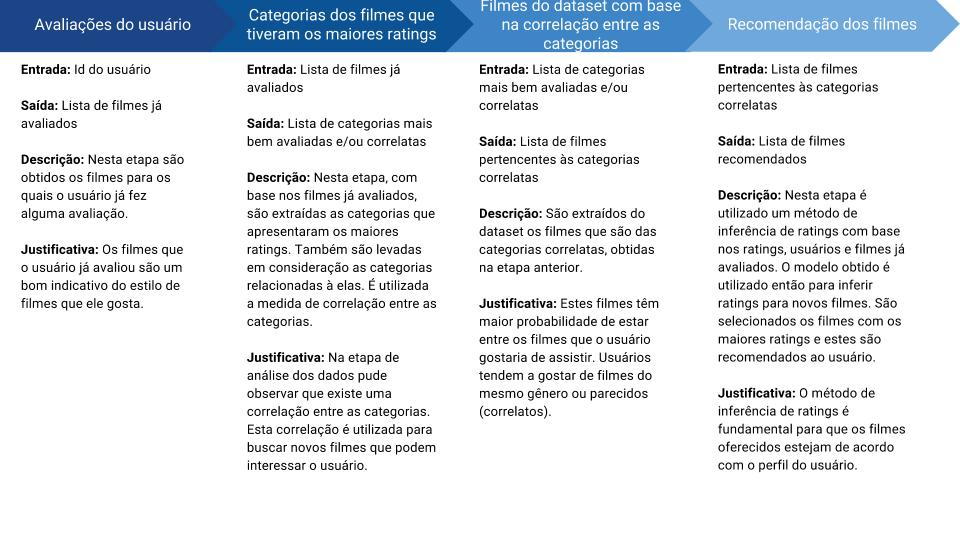

In [35]:
from IPython.display import Image
Image(filename='Overview _Sistema _Recomendação.jpg')

## Avaliações do usuário

In [41]:
# Função que retorna os filmes para os quais um usuário já deu rating.
# Retorna um Dataframe com (movieId, rating, userId)
def getUserMovies(userId):
    user_movies = dfMoviesRatingsFinal.userId == userId
    return dfMoviesRatingsFinal[user_movies][['movieId', 'rating']].sort_values(by=['rating'], ascending=False)

In [53]:
idtest = 6
usersMovies = getUserMovies(idtest)

In [54]:
# Preview do dataframe retornado na função
usersMovies.head()

,movieId,rating
8510,293,10.0
75865,5952,10.0
79919,7153,10.0
29140,1204,10.0
82767,8874,9.0


## Categorias dos filmes que tiveram os maiores ratings

In [55]:
# Função recebe um vetor com os ids dos filmes
# Retorna uma lista com as categorias dos filmes passados
def getCategories(moviesId):
    # Obtem as categorias com os maiores ratings
    uniqueCategories = []
    for idMov in moviesId:
        cat = dfMovies[dfMovies.movieId == idMov].genres
        categories = cat.str.split(pat="|", expand=True).values
        for categorie in categories[0]:
            uniqueCategories.append(categorie)
        
    return np.unique(uniqueCategories)

In [65]:
# Função que retorna as categorias dos maiores e menores ratings dados pelo usuário
# Retorna a lista das categorias para ass quais o usuário deu o maior rating
def getBestCategories(usersMovies):
    # Obtem maior e menor rating dado pelo usuário
    maxRating = np.max(usersMovies.rating.values)
    minRating = np.min(usersMovies.rating.values)
    
    # Ids dos filmes com os maiores ratings
    hightestRatingIds = usersMovies[usersMovies.rating == maxRating].movieId.values
    # Categorias com os maiores ratings
    highestRatingCategories = getCategories(hightestRatingIds)

    # Ids dos filmes com os menores ratings
    lowestRatingIds = usersMovies[usersMovies.rating == minRating].movieId.values
    # Categorias com os menores ratings
    lowestRatingCategories = getCategories(lowestRatingIds)

    # Obtem as categorias com o maior rating, excluindo as categorias que aparecem entre os menores ratings
    categories = list(set(highestRatingCategories) - set(lowestRatingCategories))

    return categories

In [66]:
bestCategories = getBestCategories(usersMovies)

In [67]:
bestCategories

['Adventure', 'Action', 'War', 'Crime', 'Fantasy']

## Filmes do dataset com base na correlação entre as categorias

#### Extrai a correlação entre as categorias

In [72]:
# Função que busca as categorias com as maiores e menores correlações
# Retorna duas listas ordenadas com: (categoria, categoria correlata, medida de correlação)
def getMostCorrelatedCategories(bestCategories):
    # Calcula a matriz de correlação entre as categorias
    corr = dfMoviesRatingsFinal.drop(['movieId', 'rating', 'NumberRatings', 'userId'],1).corr()
    corr[corr == 1] = None
    dfMoviesRatingsFinal
    
    # Obtem as colunas referentes as categorias
    bestCategoriesColumns = corr[bestCategories]
    # Busca as maiores correlações entre as categorias
    mostCorrelatedCategories = []
    for col in bestCategories:
        mostCorrelatedCategories.append([col, bestCategoriesColumns[col].idxmax(), 
                                         bestCategoriesColumns[col].max()])
    # Busca as maiores correlações entre as categorias
    lessCorrelatedCategories = []
    for col in bestCategories:
        lessCorrelatedCategories.append([col, bestCategoriesColumns[col].idxmin(), 
                                         bestCategoriesColumns[col].min()])
    # Ordena o resultado
    mostCorrelatedCategories = sorted(mostCorrelatedCategories, key=lambda tup: abs(tup[2]), reverse=True) 
    lessCorrelatedCategories = sorted(lessCorrelatedCategories, key=lambda tup: abs(tup[2]), reverse=True) 
    
    return mostCorrelatedCategories, lessCorrelatedCategories

In [73]:
mostCorrelatedCategories, lessCorrelatedCategories = getMostCorrelatedCategories(bestCategories)

[['Adventure', 'Action', 0.3327234317761531], ['Action', 'Adventure', 0.3327234317761531], ['Fantasy', 'Children', 0.32842691235204413], ['Crime', 'Thriller', 0.29438304868953202], ['War', 'Drama', 0.17942529602249774]]
[['Adventure', 'Drama', -0.27022273140736541], ['Action', 'Drama', -0.24945009079411273], ['Crime', 'Adventure', -0.17563640255880617], ['Fantasy', 'Drama', -0.15625741703470586], ['War', 'Thriller', -0.086966290845840774]]


In [79]:
print("Categorias com as maiores correlações: {}".format(mostCorrelatedCategories))
print("\nCategorias com as menores correlações: {}".format(lessCorrelatedCategories))

Categorias com as maiores correlações: [['Adventure', 'Action', 0.3327234317761531], ['Action', 'Adventure', 0.3327234317761531], ['Fantasy', 'Children', 0.32842691235204413], ['Crime', 'Thriller', 0.29438304868953202], ['War', 'Drama', 0.17942529602249774]]

Categorias com as menores correlações: [['Adventure', 'Drama', -0.27022273140736541], ['Action', 'Drama', -0.24945009079411273], ['Crime', 'Adventure', -0.17563640255880617], ['Fantasy', 'Drama', -0.15625741703470586], ['War', 'Thriller', -0.086966290845840774]]


#### Extrai o conjunto de filmes com base nas correlações entre as categorias

In [88]:
# Função que recebe duas listas com as categorias mais correlacionadas e a menos correlacionadas
# Retorna uma lista de filmes extraídos do dataset  
def getListOfMovies(mostCorrelatedCategories, lessCorrelatedCategories):
    # Para cada par de categorias correlacionadas
    listMovies = []
    for corrCategories in mostCorrelatedCategories:
        catA = corrCategories[0]
        catB = corrCategories[1]
        if( len(listMovies) == 0 ):
            a = np.unique(dfMoviesRatingsFinal[dfMoviesRatingsFinal[catA] == 1].movieId.values)
            b = np.unique(dfMoviesRatingsFinal[dfMoviesRatingsFinal[catB] == 1].movieId.values)
            listMovies = np.intersect1d(a, b)
        else:
            b = np.unique(dfMoviesRatingsFinal[dfMoviesRatingsFinal[catB] == 1].movieId.values)
            # Previne que a função retorne menos de 100 filmes para um determinado usuário
            if(len(np.intersect1d(listMovies, b)) < 250):
                break;
            else:
                listMovies = np.intersect1d(listMovies, b)
    
    # Remove os filmes das categorias com as correlações negativas
    for corrCategories in lessCorrelatedCategories:
        catB = corrCategories[1]

        b = np.unique(dfMoviesRatingsFinal[dfMoviesRatingsFinal[catB] == 1].movieId.values)
        # Previne que a função retorne menos de 250 filmes para um determinado usuário
        if(len(set(listMovies) - set(b)) < 250):
            continue;
        else:
            listMovies = set(listMovies) - set(b)  
    
    return listMovies

In [89]:
listOfMovies = getListOfMovies(mostCorrelatedCategories, lessCorrelatedCategories)

In [90]:
listOfMovies

{10,
 15,
 44,
 95,
 112,
 153,
 160,
 170,
 208,
 260,
 316,
 380,
 393,
 434,
 442,
 464,
 480,
 485,
 494,
 533,
 546,
 547,
 552,
 558,
 610,
 648,
 653,
 688,
 704,
 733,
 736,
 761,
 780,
 809,
 836,
 849,
 908,
 940,
 1049,
 1127,
 1129,
 1196,
 1197,
 1198,
 1200,
 1201,
 1210,
 1215,
 1274,
 1275,
 1291,
 1356,
 1370,
 1374,
 1375,
 1429,
 1495,
 1499,
 1517,
 1525,
 1527,
 1544,
 1552,
 1562,
 1587,
 1591,
 1606,
 1610,
 1681,
 1722,
 1744,
 1831,
 2005,
 2041,
 2094,
 2105,
 2115,
 2153,
 2193,
 2275,
 2366,
 2373,
 2376,
 2402,
 2404,
 2405,
 2406,
 2414,
 2471,
 2528,
 2617,
 2628,
 2640,
 2642,
 2643,
 2683,
 2720,
 2735,
 2748,
 2826,
 2879,
 2916,
 2947,
 2948,
 2949,
 2989,
 2990,
 2991,
 2993,
 3030,
 3082,
 3153,
 3440,
 3623,
 3624,
 3633,
 3635,
 3638,
 3639,
 3702,
 3703,
 3704,
 3740,
 3745,
 3771,
 3793,
 3827,
 3864,
 3877,
 3889,
 3959,
 3984,
 3997,
 3999,
 4005,
 4121,
 4133,
 4232,
 4270,
 4275,
 4367,
 4566,
 4638,
 4799,
 4915,
 4941,
 5040,
 5171,
 5313,

## Recomendação dos Filmes